# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## <span style="color:blue">  Svolgimento</span>

Si è optato per implementare il calcolo parallelo tramite libreria MPI nel Genetic Algorithm (GA) dell'esercitazione 9. 

L'idea iniziale era di utilizzare 8 core secondo un modello Single Program Many Data (SPMD) in modo tale che ogni core eseguisse l'algorirmo genetico in maniera parallela, studiando la casistica senza migrazioni tra i continenti e la casistica che permette lo scambio di informazioni. I diversi nodi utilizzano 8 generatori di numeri pseudocasuali distinti e pertanto indipendenti, nei file di output di ciascuno nodo sono riportati gli andamenti . Al termine della ricerca gli 8 migliori individui sono stati raccolti attraverso la funzione Gather() e riordinati in modo da ottenere l'individuo migliori tra tutti. Lo scambio di informazioni tra nodi segue la seguente procedura:  viene estratto un numero $j$ tra $(1,size)$ tramite un generatore condiviso tra i nodi, ogni nodo invierà tramite la funzione Sendrecev() il proprio miglior individuo al nodo in posizione rank+j.

Dato il carico computazionale del programma, il mio calcolatore non ha permesso di eseguire pienamente questa procedura, nonostante comunque sia riuscito a trovare una soluzione soddisfacente al problema. Si ha infatti che nel caso di 8 core, alcuni nodi non siano riusciti a completare il programma nel caso delle migrazioni. Per completezza sono comunque stati riportati anche gli esiti di tali simulazioni. 

L'unica opzione che non comportasse questo problema è stata quella di utilizzare solamente due core. Di seguito si riportano i risultati sia in assenza che in presenza di migrazione.


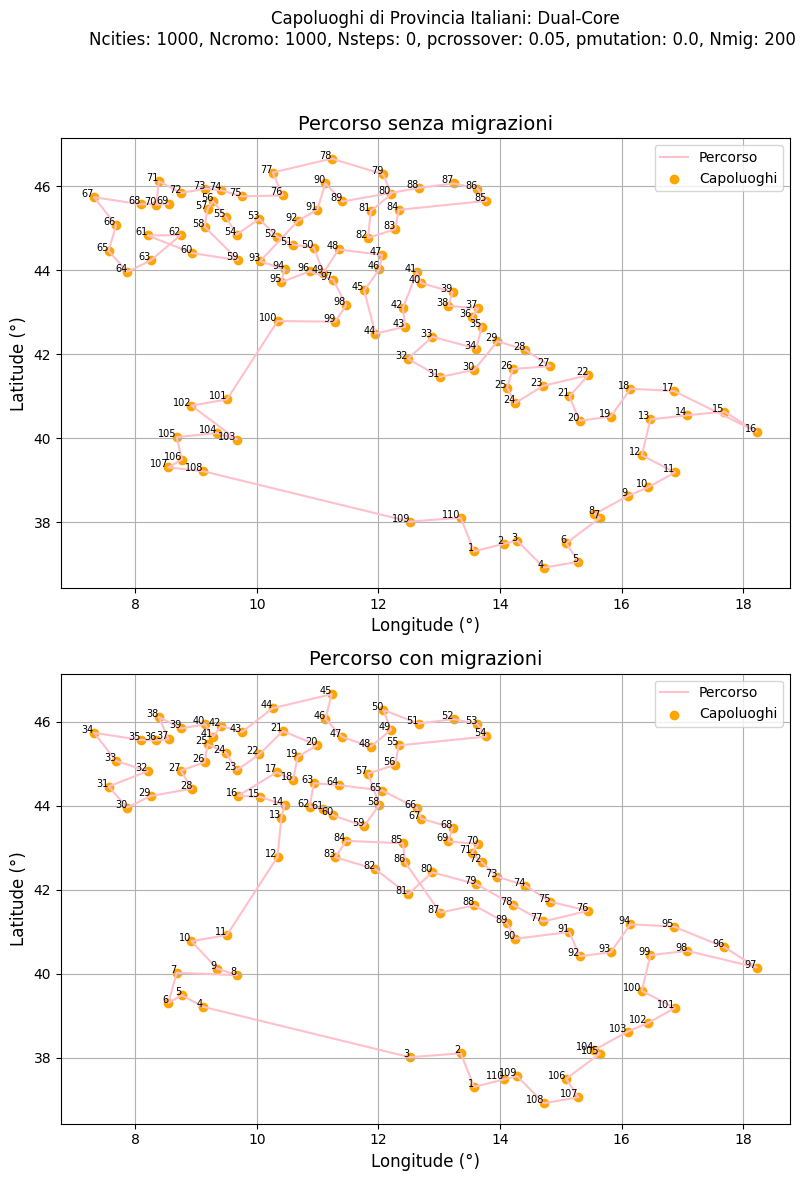

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Caricamento delle coordinate della mappa circolare
map_data = np.loadtxt("cap_prov_ita.dat")
x = map_data[:, 0]
y = map_data[:, 1]

# Funzione per leggere i dati di input dal file
def read_input_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        data = []
        for line in lines:
            if line.strip() and not line.startswith('N_Città'):
                values = line.split()
                for value in values:
                    try:
                        data.append(float(value))
                    except ValueError:
                        pass
    return np.array(data)

# Leggi i dati di input
input_data = read_input_data("input.dat")
Ncities, Ncromo, Nsteps, pcrossover, pmutation = input_data

# Creazione del grafico con due sottoplot in verticale
fig, axs = plt.subplots(2, 1, figsize=(9, 12))
subtitle = (f'Ncities: {int(Ncities)}, Ncromo: {int(Ncromo)}, Nsteps: {int(Nsteps)}, '
            f'pcrossover: {pcrossover}, pmutation: {pmutation}, Nmig: {200} ')
fig.suptitle("Capoluoghi di Provincia Italiani: Dual-Core\n" + subtitle)

# Iterazione su entrambi i sottoplot
for i, migration_file in enumerate(["Results_dual-core/best.data", "Results_dual-core/bestmigration.data"]):
    # Dati degli indici migliori
    best = np.loadtxt(migration_file)
    indices = [int(index) for index in best]

    # Creazione di coppie di punti collegati in base all'ordine degli indici
    connected_points = [(x[index], y[index]) for index in indices]
    connected_points.append((x[indices[0]], y[indices[0]]))

    # Traccia del percorso e scatter plot
    axs[i].plot(*zip(*connected_points), '-', label='Percorso', color="pink")
    axs[i].scatter(x, y, c='orange', label='Capoluoghi', alpha=1)

    # Numerazione dei capoluoghi
    for idx, (xp, yp) in enumerate(connected_points[:-1], start=1):
        axs[i].text(xp, yp, str(idx), fontsize=7, ha='right')

    # Impostazione delle etichette degli assi e del titolo
    axs[i].set_xlabel('Longitude (°)', fontsize=12)
    axs[i].set_ylabel('Latitude (°)', fontsize=12)
    axs[i].set_title(f'Percorso {"senza" if i == 0 else "con"} migrazioni', fontsize=14)
    axs[i].grid(True)
    axs[i].legend(loc='upper right', fontsize=10)


# Mostra il grafico
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

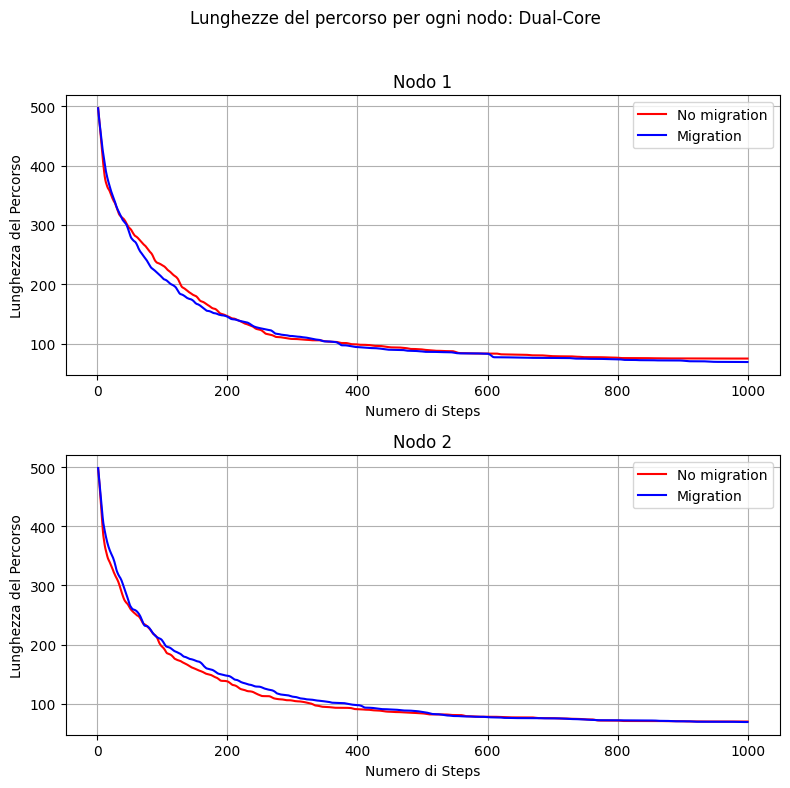

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Creazione della figura con sottoplot 4x2
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
fig.suptitle("Lunghezze del percorso per ogni nodo: Dual-Core")

# Iterazione su tutti i nodi
for node in range(2):
    # Seleziona il sottoplot corrente
    ax = axes[node]

    # File con i dati delle lunghezze dei percorsi del nodo corrente
    lengths_file_nomigr = f"Results_dual-core/bestlength_{node}.data"
    lengths_file_migr = f"Results_dual-core/bestlengthmigration_{node}.data"

    # Dati delle lunghezze dei percorsi
    lengths_nomigr = np.loadtxt(lengths_file_nomigr)
    averages_nomigr = np.mean(lengths_nomigr, axis=1)

    lengths_migr = np.loadtxt(lengths_file_migr)
    averages_migr = np.mean(lengths_migr, axis=1)

    # Traccia delle lunghezze dei percorsi
    ax.plot(range(1, len(averages_nomigr) + 1), averages_nomigr, color='red', label='No migration')
    ax.plot(range(1, len(averages_migr) + 1), averages_migr, color='blue', label='Migration')

    # Impostazione delle etichette degli assi e della legenda
    ax.set_xlabel('Numero di Steps')
    ax.set_ylabel('Lunghezza del Percorso')
    ax.set_title(f'Nodo {node+1}')
    #ax.set_ylim(60,200)
    ax.grid()
    ax.legend()

# Mostra tutti i grafici in modo ordinato
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Aggiustamento dei margini per il titolo
plt.show()

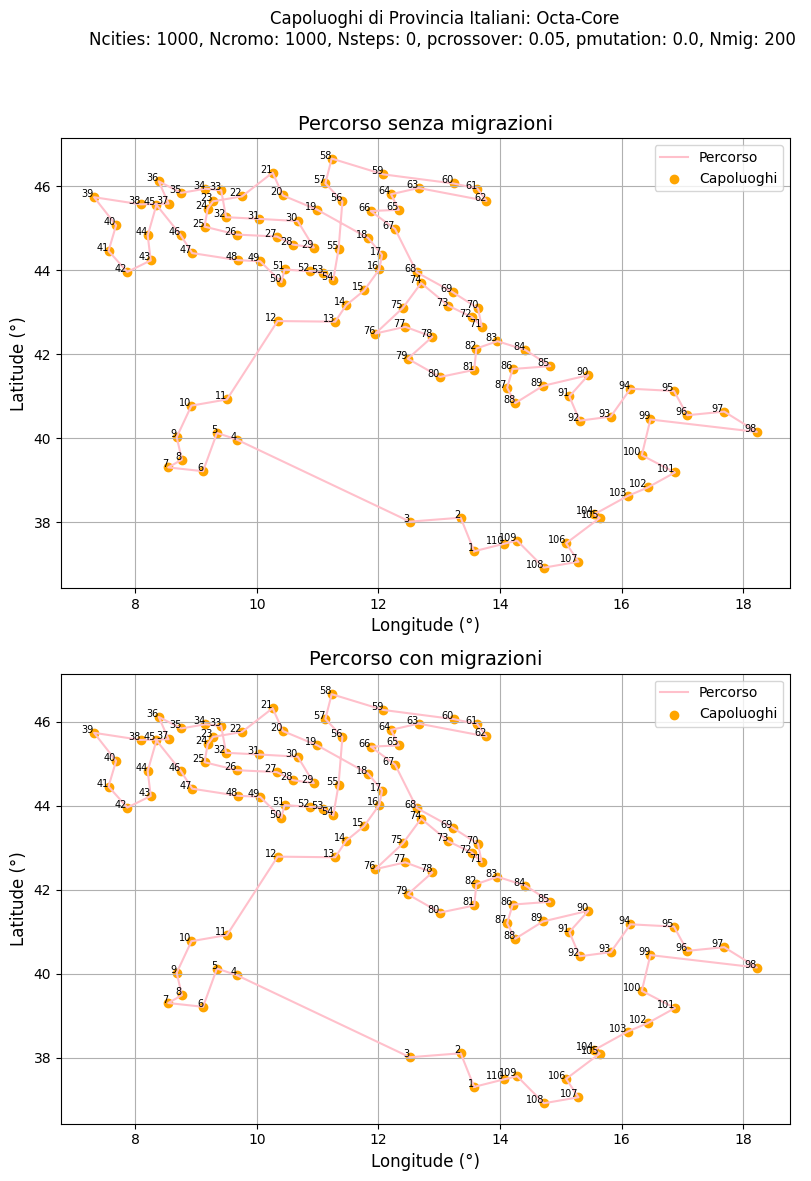

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Caricamento delle coordinate della mappa circolare
map_data = np.loadtxt("cap_prov_ita.dat")
x = map_data[:, 0]
y = map_data[:, 1]

# Funzione per leggere i dati di input dal file
def read_input_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        data = []
        for line in lines:
            if line.strip() and not line.startswith('N_Città'):
                values = line.split()
                for value in values:
                    try:
                        data.append(float(value))
                    except ValueError:
                        pass
    return np.array(data)

# Leggi i dati di input
input_data = read_input_data("input.dat")
Ncities, Ncromo, Nsteps, pcrossover, pmutation = input_data

# Creazione del grafico con due sottoplot in verticale
fig, axs = plt.subplots(2, 1, figsize=(9, 12))
subtitle = (f'Ncities: {int(Ncities)}, Ncromo: {int(Ncromo)}, Nsteps: {int(Nsteps)}, '
            f'pcrossover: {pcrossover}, pmutation: {pmutation}, Nmig: {200} ')
fig.suptitle("Capoluoghi di Provincia Italiani: Octa-Core\n" + subtitle)

# Iterazione su entrambi i sottoplot
for i, migration_file in enumerate(["Results_Octa-core/best.data", "Results_octa-core/bestmigration.data"]):
    # Dati degli indici migliori
    best = np.loadtxt(migration_file)
    indices = [int(index) for index in best]

    # Creazione di coppie di punti collegati in base all'ordine degli indici
    connected_points = [(x[index], y[index]) for index in indices]
    connected_points.append((x[indices[0]], y[indices[0]]))

    # Traccia del percorso e scatter plot
    axs[i].plot(*zip(*connected_points), '-', label='Percorso', color="pink")
    axs[i].scatter(x, y, c='orange', label='Capoluoghi', alpha=1)

    # Numerazione dei capoluoghi
    for idx, (xp, yp) in enumerate(connected_points[:-1], start=1):
        axs[i].text(xp, yp, str(idx), fontsize=7, ha='right')

    # Impostazione delle etichette degli assi e del titolo
    axs[i].set_xlabel('Longitude (°)', fontsize=12)
    axs[i].set_ylabel('Latitude (°)', fontsize=12)
    axs[i].set_title(f'Percorso {"senza" if i == 0 else "con"} migrazioni', fontsize=14)
    axs[i].grid(True)
    axs[i].legend(loc='upper right', fontsize=10)


# Mostra il grafico
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

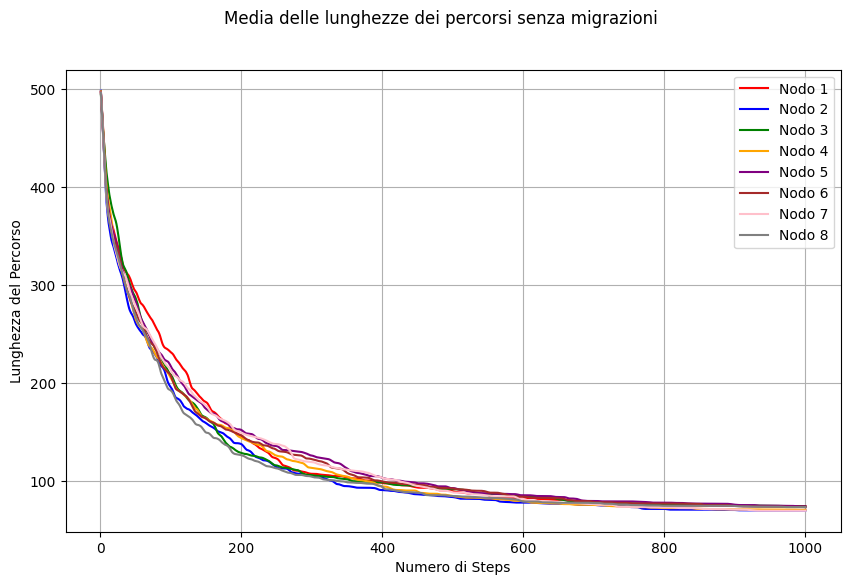

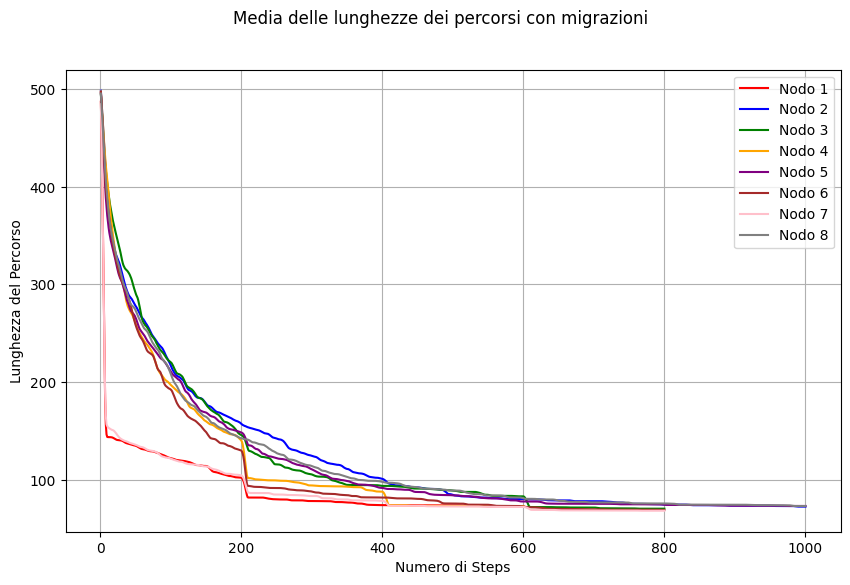

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Creazione delle due figure
fig_nomigr, axs_nomigr = plt.subplots(figsize=(10, 6))
fig_nomigr.suptitle("Media delle lunghezze dei percorsi senza migrazioni")

fig_migr, axs_migr = plt.subplots(figsize=(10, 6))
fig_migr.suptitle("Media delle lunghezze dei percorsi con migrazioni")

# Colori per i plot dei nodi
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Iterazione su tutti i nodi
for node in range(8):
    # File con i dati delle lunghezze dei percorsi del nodo corrente
    lengths_file_nomigr = f"Results_octa-core/bestlength_{node}.data"
    lengths_file_migr = f"Results_octa-core/bestlengthmigration_{node}.data"

    # Dati delle lunghezze dei percorsi
    lengths_nomigr = np.loadtxt(lengths_file_nomigr)
    averages_nomigr = np.mean(lengths_nomigr, axis=1)

    lengths_migr = np.loadtxt(lengths_file_migr)
    averages_migr = np.mean(lengths_migr, axis=1)

    # Traccia delle lunghezze dei percorsi nella figura senza migrazioni
    axs_nomigr.plot(range(1, len(averages_nomigr) + 1), averages_nomigr, color=colors[node], label=f'Nodo {node+1}')

    # Traccia delle lunghezze dei percorsi nella figura con migrazioni
    axs_migr.plot(range(1, len(averages_migr) + 1), averages_migr, color=colors[node], label=f'Nodo {node+1}')

# Impostazione delle etichette degli assi e delle legende
axs_nomigr.set_xlabel('Numero di Steps')
axs_nomigr.set_ylabel('Lunghezza del Percorso')
axs_nomigr.legend()

axs_migr.set_xlabel('Numero di Steps')
axs_migr.set_ylabel('Lunghezza del Percorso')
axs_migr.legend()

axs_migr.grid()
axs_nomigr.grid()
# Mostra le figure
plt.show()

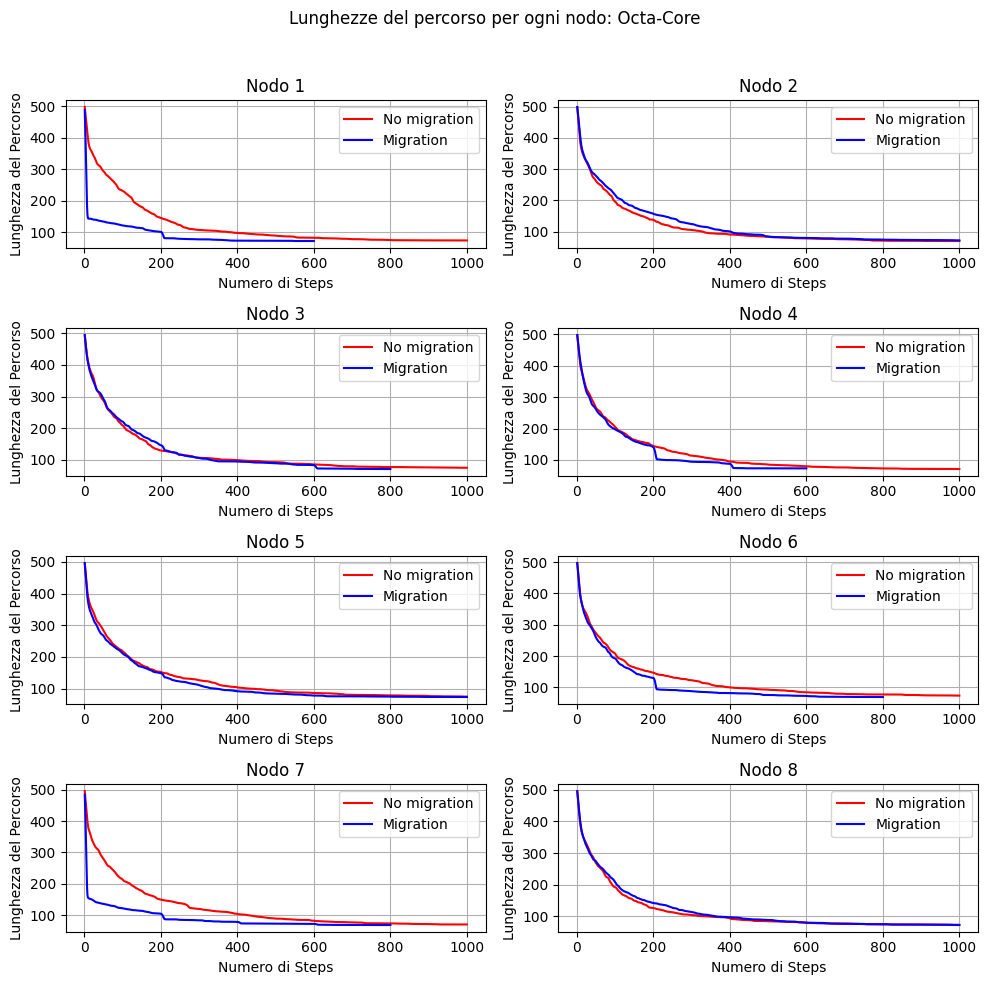

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Creazione della figura con sottoplot 4x2
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.suptitle("Lunghezze del percorso per ogni nodo: Octa-Core")

# Iterazione su tutti i nodi
for node in range(8):
    # Seleziona il sottoplot corrente
    ax = axes[node // 2, node % 2]

    # File con i dati delle lunghezze dei percorsi del nodo corrente
    lengths_file_nomigr = f"Results_octa-core/bestlength_{node}.data"
    lengths_file_migr = f"Results_octa-core/bestlengthmigration_{node}.data"

    # Dati delle lunghezze dei percorsi
    lengths_nomigr = np.loadtxt(lengths_file_nomigr)
    averages_nomigr = np.mean(lengths_nomigr, axis=1)

    lengths_migr = np.loadtxt(lengths_file_migr)
    averages_migr = np.mean(lengths_migr, axis=1)

    # Traccia delle lunghezze dei percorsi
    ax.plot(range(1, len(averages_nomigr) + 1), averages_nomigr, color='red', label='No migration')
    ax.plot(range(1, len(averages_migr) + 1), averages_migr, color='blue', label='Migration')

    # Impostazione delle etichette degli assi e della legenda
    ax.set_xlabel('Numero di Steps')
    ax.set_ylabel('Lunghezza del Percorso')
    ax.set_title(f'Nodo {node+1}')
    #ax.set_ylim(60,200)
    ax.grid()
    ax.legend()

# Mostra tutti i grafici in modo ordinato
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Aggiustamento dei margini per il titolo
plt.show()

Vale la pena osservare che si ha una convergenza più rapida del metodo con le mutazioni, dovute a dei drop in concomitanza dello scambio tra i continenti.